# THE ORIGIN OF BIASED VELOCITY ESTIMATION IN FLCT AND A PROCEDURE TO FIX IT
## George H. Fisher (SSL/UCB) and Brian T. Welsch (U. Wisconsin GB), 2018 March 5
### Transcription and formatting by Ryan Hofmann, 2022 August 22

## Introduction

The current implementation of the FLCT technique to estimate velocities from changes in two images taken at two slightly different times is described in Fisher and Welsch (2008 ASP Conf. Series, vol. 383, p. 373, henceforth FW2008). In a nutshell, for each pixel location in the pair of images, sub-images $S_1$ and $S_2$ are constructed by convolving the two images $I_1$ and $I_2$ with a Gaussian windowing function, of width $\sigma$ pixels, so that for each image, the Gaussian window function is centered on the pixel of interest. This windowing operation allows the velocity calculation to be "localized" to the pixel of interest, with the understanding that velocity components on size scales small compared to $\sigma$ will be integrated away in the convolution.  The gaussian form for the windowing function was chosen because it usually results in a smooth velocity estimate map over the domain of the images.  Mathematically, the relationship is described in equations (1) and (2) of FW2008. During the early development stages of FLCT, we considered the "top-hat" function as an alternative windowing function (equal to 1 inside a radius of $\sigma$, and 0 outside), but we found this resulted in discontinuous velocity maps, owing to the importance of intense image features close to the edge of the window that would suddenly appear or disappear from the sub-images.

Empirically, it has been found by ourselves and many other researchers that the amplitudes of $v_x$ and $v_y$ found by FLCT are frequently less than what one expects. This is particularly evident if one creates the 2nd image from the first one by directly solving the advection equation with a known flow-field, and then compares velocities or shifts returned from FLCT with those assumed in the advection equation. The degree of this velocity "under-estimation" can vary between insignificant in some cases, to disturbingly large in other cases.

Here, we describe why we believe velocity under-estimation occurs, and then suggest and implement an experimental algorithm to correct it.  This analysis also suggests an important constraint on the choice of the windowing parameter $\sigma$.

## Cause of underestimated shifts

Imagine that in a region surrounding pixel $x_i,y_j$ that the image field $I_2$ is shifted by $\Delta x$ and $\Delta y$ from the image field $I_1$:

\begin{equation}
    I_2(x', y') = I_1 (x' - \Delta x, y' - \Delta y)
\end{equation}

Here, $(x',y')$ represent distance away from the local origin, $x_i,y_j$. If the Gaussian windowing function for the sub-image $S_2$ were *also* shifted by $\Delta x, \Delta y$, then the cross-correlation function for the two sub-images would exhibit a peak at $\Delta x, \Delta y$, and the FLCT algorithm, which finds where the peak of the cross-correlation function is located, would return the correct local shift values, $\Delta x$ and $\Delta y$.

However, that is not what is done.  Instead, *both* images are convolved with the same unshifted Gaussian windowing function.  The obvious solution to this problem would be to properly shift the Gaussian windowing function for the 
2nd image.  However, that is impossible, since we are tring to find $\Delta x$ and $\Delta y$ in the first place! But, we can make progress by trying to understand what FLCT is actually doing, versus what we would like it to do.

## Derivation of underestimates (HERE BE MATHS)

Imagine that in the ideal case, we did convolve the 2nd image with a gaussian window function shifted by $\Delta x, \Delta y$ from our local origin. In that case, let us approximate the shape of the cross-correlation function as another gaussian, which we'll write 

\begin{equation}
    f(x, y) = \exp \left[-\frac{(x - \Delta x)^2 + (y - \Delta y)^2}{\gamma^2}\right]
\end{equation}

a gaussian which is centered at $\Delta x, \Delta y$, with width $\gamma$, as a function of the x-and-y lags, $x$ and $y$.

But in reality, what we have for sub-image $S_2$ is multiplication of the unshifted Gaussian in the 2nd expression of equation (1) of FH2008.  Let's re-write this in terms of the shifted gaussian, plus additional terms:

\begin{equation}
    S_2(x, y) = I_1(x - \Delta x, y - \Delta y) * \exp \left[-\frac{(x - \Delta x)^2 + (y - \Delta y)^2}{\sigma^2}\right] \\
    * \exp \left[\frac{-\Delta x}{\sigma^2} (2 x - \Delta x)\right] \\
    * \exp \left[\frac{-\Delta y}{\sigma^2} (2 y - \Delta y)\right]
\end{equation}

Thus, $S_2(x, y)$ can be written as a shift of $S_1$, multiplied by the 2nd and 3rd lines of equation (3), which represent additional multiplicative terms. These terms have no dependence on the integration variables that
occur in the definition of the cross-correlation function in equation (2) of FH2008 (Note: Confusingly, that equation uses $x$ and $y$ as the integration variables and $\delta x$ and $\delta y$ as the lag variables; here we are using $x$ and $y$ for the lag variables, and some other notation like $x'$ and $y'$ for the integration variables).

The result of this is that instead of FLCT finding the location of the peak values $\Delta x$ and $\Delta y$, it finds the location of the peak of the function

\begin{equation}
    \exp \left[\frac{-\Delta x}{\sigma^2}(2 x - \Delta x)\right] * \exp \left[\frac{-\Delta y}{\sigma^2}(2 y - \Delta y)\right] \\
    * \exp \left[ - \frac{(x - \Delta x)^2}{\gamma^2} - \frac{(y - \Delta y)^2}{\gamma^2} \right]
\end{equation}

where the 2nd line in equation (4) is the gaussian approximating the correctly shifted cross-correlation function that is defined in equation (2).

Setting the first derivative of the quantity in equation (4) with respect to $x$ to 0, we find

\begin{equation}
    - \frac{2 * \Delta x}{\sigma^2} - \frac{2 ( x - \Delta x)}{\gamma^2} = 0
\end{equation}

and setting the first derivative of this quantity with respect to $y$ to 0, we find

\begin{equation}
    - \frac{2 * \Delta y}{\sigma^2} - \frac{2 ( y - \Delta y)}{\gamma^2} = 0.
\end{equation}

The solution to equation (5) can be written

\begin{equation}
    \Delta x = \frac{x}{1 - \gamma^2 / \sigma^2},
\end{equation}

and the solution to equation (6) is

\begin{equation}
    \Delta y = \frac{y}{1 - \gamma^2 / \sigma^2}.
\end{equation}

Here, $x$ and $y$ are the locations of the peak of the function in equation (4), and these values are what FLCT finds.  Equations (7) and (8) show that provided $\gamma^2/\sigma^2 < 1$, $x$ and $y$ are always smaller in amplitude than the true shifts, $\Delta x$ and $\Delta y$.

Equations (7) and (8) also reveal that the ratio $\gamma^2/\sigma^2$ is an important quantity determining the behavior of FLCT:  The smaller this ratio, the more accurate the FLCT results are.  If this ratio exceeds unity, the correction expressions formally become singular, but we believe that what this says is that above this limit, FLCT results are unreliable. This consideration favors larger values of $\sigma$.  On the other hand, $\sigma$ also determines the size scale of velocity flows that can be detected, with smaller values of $\sigma$ allowing for a broader possible range of velocity scales, including smaller size scales, that can be determined.  Thus a choice of $\sigma$ needs to balance both of these considerations.

## How do we find the quantity $\gamma^2$?

The above analysis of bias is somewhat over-simplified.  The region near peak of the cross-correlation function is generally not a simple, azimuthally symmetric gaussian.  Instead, conditions near the peak are specified by the values of all of the 2nd derivatives at the peak, which here we'll denote $f_{xx}$, $f_{yy}$, and $f_{xy}$, the 2nd derivative with respect to the x-lag, the 2nd derivative with respect to the y-lag, and the cross partial derivative with respect to the x-and y-lags, respectively.

The 2nd derivatives at the peak constitute the array elements of the 2D "Hessian" matrix, which we denote

\begin{equation}
    M = 
    \begin{bmatrix}
        f_{xx} & f_{xy} \\
        f_{xy} & f_{yy}
    \end{bmatrix}
\end{equation}

Generally speaking, $f_{xx}$ and $f_{yy}$ will be negative if the function is at a peak, but an additional statement is that the Hessian determinant,

\begin{equation}
    H = f_{xx} * f_{yy} - f_{xy}^2
\end{equation}

is positive if we are at the peak of the function $f$.  Furthermore, $H$ is invariant under a rotation of the coordinate system.  Eigenvalues of $M$ can be found, and the corresponding eigenvectors provide coordinate axes which diagonalize $M$.

The eigenvalues $\lambda_1, \lambda_2$ for $M$ are:

\begin{equation}
    \lambda_1 = (0.5*f_{xx} + 0.5*f_{yy}) + \sqrt{(0.5*f_{xx} - 0.5*f_{yy})^2 + f_{xy}^2} \\
    \lambda_2 = (0.5*f_{xx} + 0.5*f_{yy}) - \sqrt{(0.5*f_{xx} - 0.5*f_{yy})^2 + f_{xy}^2}
\end{equation}

The ratio of the two eigenvalues indicates the eccentricity, or "ovalicity" of the cross-correlation function near the peak.  The product of the eigenvalues is simply equal to the Hessian determinant $H$, meaning we can regard $H^{1/2}$ as a geometric mean of the maximum and minimum of the 2nd derivatives represented by the two eigenvalues.  The Hessian determinant $H$ therefore is an excellent candidate for defining a quantity we can use to determine the quantity $\gamma^2$ in equations (7) and (8).

But first, we note that $H$ has units of length$^{-4}$, whereas $\gamma^2$ has units of length$^2$.  Second, we note that the cross-correlation function can (and does!) have an arbitrary amplitude, where our assumptions in equation (2) assume a maximum value of unity.

So first, we define a normalized version of $H$, $H_n$, in which the peak of the cross-correlation function is normalized to unity:

\begin{equation}
    H_n = \frac{f_{xx} * f_{yy}}{f_p^2} - \frac{f_{xy}^2}{f_p^2},
\end{equation}

where $f_p$ is the peak value of the un-normalized cross-correlation function computed within FLCT. $(H_n)^{1/2}$ is the geometric mean between the maximum and minimum values of the normalized 2nd derivatives taken in the directions of the two eigenvectors.

Second, we note that we can match the units of $\gamma^2$, by taking $H_n^{-1/2}$:

\begin{equation}
    \gamma^2 = H_n^{-1/2}.
\end{equation}

Using equation (14) in equations (7) and (8), we evaluated shifts in a test case, in which we used an HMI magnetogram image of AR 11158 to create a second image, in which a + 0.5 pixel uniform shift is applied in the 
x-direction, and a -0.5 pixel uniform shift is applied in the y-direction. The warp program, included in this distribution, was used to create the 2nd image.  Equations (7) and (8) greatly improved the biases returned by FLCT. But we found that the behavior of equations (7) and (8) could be further improved by adding an empirical factor of 0.8 in the denominator of equations (7) and (8):

\begin{equation}
    \Delta x = \frac{x}{1. - 0.8*\gamma^2/\sigma^2},
\end{equation}

and

\begin{equation}
    \Delta y = \frac{y}{1. - 0.8*\gamma^2/\sigma^2}.
\end{equation}

To avoid singularities, we cap the computed value of $\gamma^2/\sigma^2$ at 0.95.

The values of $\gamma^2/\sigma^2$ can be affected by other FLCT parameters. For example, the width of the cross-correlation function is strongly affected by the use of filtering, and the choice of the filter parameter.  In using the filter parameter ("-k kr" in the command-line, where kr is typically in the range 0.25-1.0), stronger filtering (lower values of kr) can result in substantially broader cross-correlation functions, and thus larger values of $\gamma^2/\sigma^2$.  FLCT versions 1.06 (and later) print out the mean value of $\gamma^2/\sigma^2$ as a diagnostic when run from the command-line.

In [1]:
# Let's see this in action! First, we'll import the necessary stuff.
import numpy as np
from scipy import signal
from scipy.ndimage import median_filter
from astropy.io import fits
import matplotlib.pyplot as plt
from python.destretch import *
from matplotlib.colors import LogNorm
plt.rcParams['figure.dpi'] = 169

In [2]:
# Open some test data...
data = fits.open('test/test.fits')[0].data
data.shape

(11, 1000, 1000)

(100, 100)


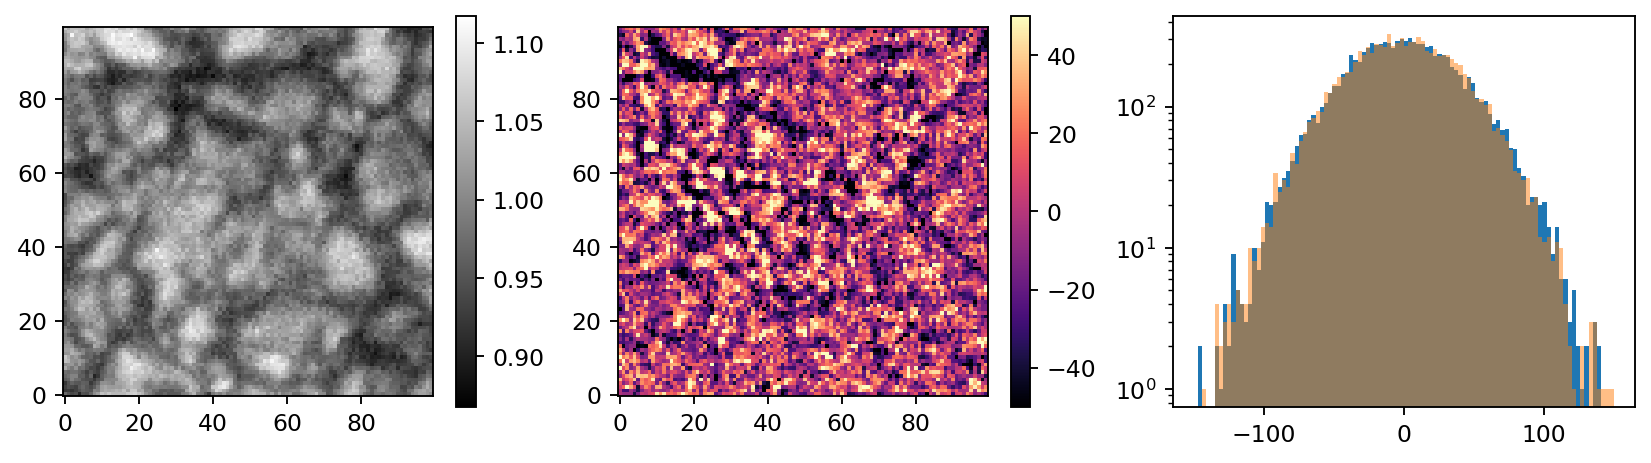

In [26]:
# ...and give it a look.
plt.figure(figsize=(12, 3))
plt.subplot(131)
im_raw = data[7][450:550, 450:550]
plt.imshow(im_raw/3600., origin='lower', cmap='grey')
plt.colorbar()
plt.subplot(132)
im_wiener = signal.wiener(data[7])[450:550, 450:550]
im_median = np.median(data, 0)[450:550, 450:550]
print(im_median.shape)
noise = np.random.default_rng().normal(0, 1, im_wiener.shape)*im_wiener.mean()
snr = 88
#plt.imshow(im_median, origin='lower', cmap='magma', vmin=3200, vmax=4000)
#plt.imshow(im_wiener + noise/snr, origin='lower', cmap='magma', vmin=3200, vmax=4000)
plt.imshow(im_median -im_wiener, origin='lower', cmap='magma', vmin=-50, vmax=50)
#plt.imshow(noise/snr, origin='lower', cmap='magma', vmin=-150, vmax=150)
plt.colorbar()
# plt.imshow(np.median(data, 0), origin='lower', cmap='magma')
# plt.axis([400, 600, 400, 600])
plt.subplot(133)
plt.hist((im_raw - im_wiener).ravel(), bins=np.linspace(-150, 150, 101))
plt.hist(noise.ravel()/snr, bins=np.linspace(-150, 150, 101), alpha=0.5)
# plt.plot(np.linspace(-150, 150, 301), 29600*np.exp(-np.linspace(-150, 150, 301)**2/(2*41**2)))
plt.yscale('log')

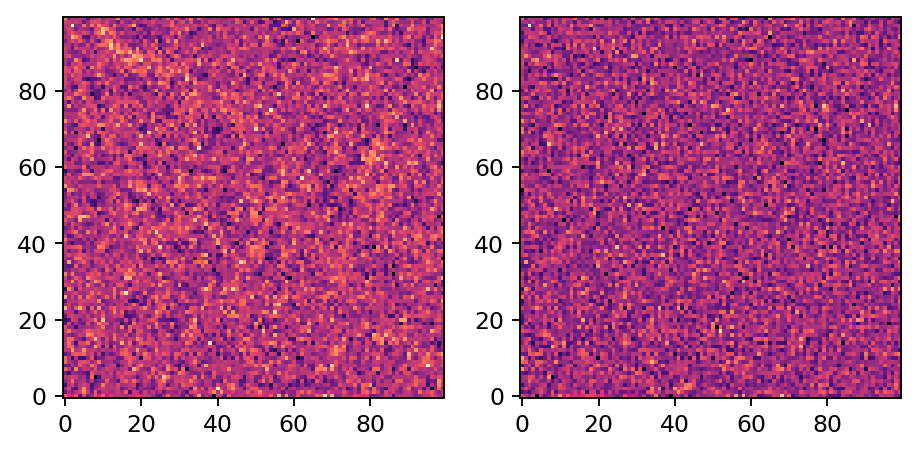

In [27]:
plt.subplot(121)
plt.imshow(im_raw - im_median, origin='lower', cmap='magma')
plt.subplot(122)
plt.imshow(im_raw - im_wiener, origin='lower', cmap='magma')

Text(0.5, 1.0, '0.7695852916475142')

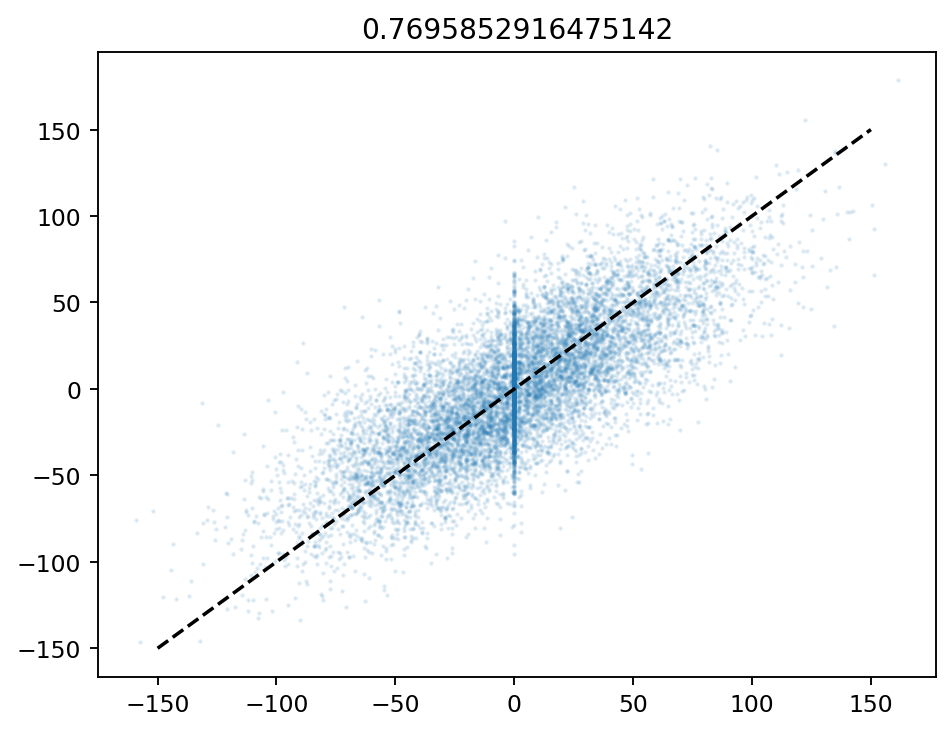

In [28]:
plt.scatter((im_raw - im_median).ravel(), (im_raw - im_wiener).ravel(), s=1, alpha=0.1)
plt.plot([-150, 150], [-150, 150], '--k')
plt.title(np.corrcoef((im_raw - im_median).ravel(), (im_raw - im_wiener).ravel())[0, 1])

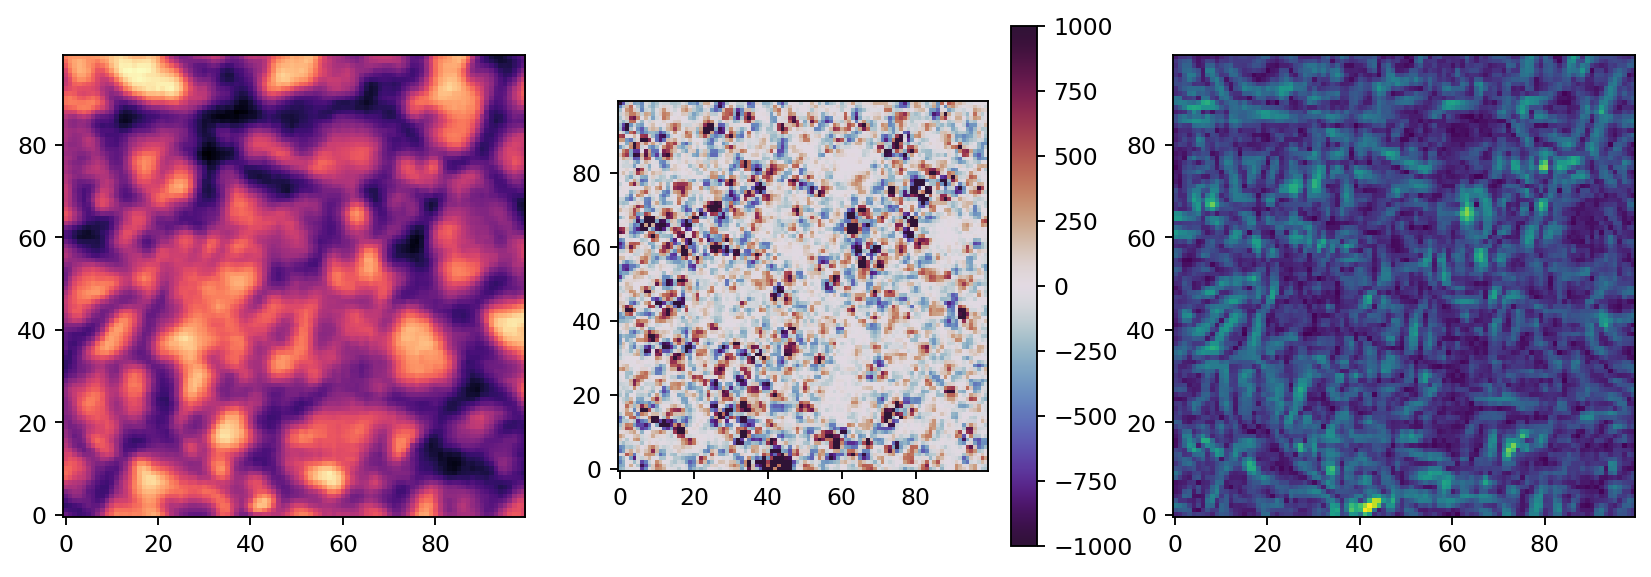

In [40]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(im_wiener, origin='lower', cmap='magma')
plt.subplot(132)
f_xx = np.gradient(np.gradient(im_wiener, 1, axis=1), 1, axis=1)
f_xy = np.gradient(np.gradient(im_wiener, 1, axis=1), 1, axis=0)
f_yy = np.gradient(np.gradient(im_wiener, 1, axis=0), 1, axis=0)
plt.imshow(f_xx*f_yy - f_xy**2, origin='lower', cmap='twilight_shifted', vmin=-1000, vmax=1000)
plt.subplot(133)
plt.imshow(np.sqrt(f_xx**2 + f_yy**2), origin='lower')
# plt.axis([400, 600, 400, 600])
# plt.colorbar()

Text(0.5, 1.0, '-2.99915, -2.99913')

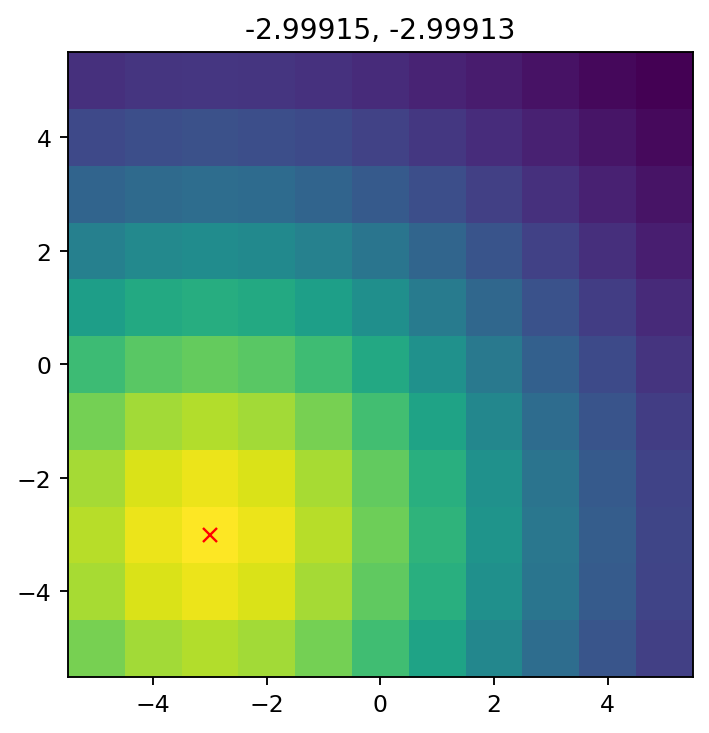

In [30]:
# Now, we'll start by testing the FLCT algorithm on the whole field at once.
# Inferred shifts are pretty darn close!
dx, dy = -3, -3
pad = 20
apod_frac = 0.3
snr = 88000
# im0 = data[5, pad:-pad, pad:-pad].copy()
# im0 = np.median(data, 0)[pad:-pad, pad:-pad].copy()
im0 = signal.wiener(data[0])[pad:-pad, pad:-pad].copy()
# im1 = data[5, pad+dy:dy-pad, pad+dx:dx-pad].copy()
# im1 = np.median(data, 0)[pad+dy:dy-pad, pad+dx:dx-pad].copy()
im1 = signal.wiener(data[0])[pad+dy:dy-pad, pad+dx:dx-pad].copy()
ny, nx = im0.shape
rng = np.random.default_rng()
im0 += rng.normal(size=im0.shape)*im0.mean()/snr
im1 += rng.normal(size=im0.shape)*im0.mean()/snr
im0 -= surface_fit(im0, 1)
im1 -= surface_fit(im1, 1)
window = apod_mask(nx, ny, fraction=apod_frac)
window_shifted = np.zeros((ny, nx))
wsx0, wsx1, wsy0, wsy1 = max(-dx, 0), min(-dx, 0)+nx, max(-dy, 0), min(-dy, 0)+ny
window_shifted[wsy0:wsy1, wsx0:wsx1] = window[wsy0+dy:wsy1+dy, wsx0+dx:wsx1+dx]
lowpass = smouth(nx, ny)
# lowpass = np.ones((nx, ny))
s0 = im0 * window
s1 = im1 * window
# s1 = im1 * window_shifted
fft_s0 = np.fft.fft2(s0)
fft_s1 = np.fft.fft2(s1)
cc = np.abs(np.fft.fftshift(np.fft.ifft2(fft_s0 * fft_s1.conj()*lowpass)))
# cc_sft = np.roll(cc, (ny//2, nx//2), axis=(0, 1))
mx, my = crosscor_maxpos(cc, 2)
mx = (mx + nx) % nx - nx//2
my = (my + ny) % ny - ny//2
cc_range = 5
plt.imshow(cc[ny//2-cc_range:ny//2+cc_range+1, nx//2-cc_range:nx//2+cc_range+1],
           extent=[-cc_range-0.5, cc_range+0.5, -cc_range-0.5, cc_range+0.5], origin='lower')
plt.plot(mx, my, 'xr')
plt.title('{:.5f}, {:.5f}'.format(mx, my))

In [31]:
# Calculate the Hessian determinant and obtain gamma^2.
cc_xx = np.gradient(np.gradient(cc, axis=1), axis=1)
cc_xy = np.gradient(np.gradient(cc, axis=0), axis=1)
cc_yy = np.gradient(np.gradient(cc, axis=0), axis=0)
Hn = (cc_xx*cc_yy - cc_xy**2)[round(my) + ny//2, round(mx) + nx//2] / np.amax(cc)**2
gamma2 = Hn**-0.5
print(gamma2)

20.536003719347892


In [32]:
# Apply the correction. For the full-field, not much changes.
delta_x = mx / (1 - 0.8*gamma2/(0.25*nx)**2)
delta_y = my / (1 - 0.8*gamma2/(0.25*ny)**2)
print(delta_x, delta_y)

-3.0000032804947976 -2.9999818331891115


Text(0.5, 1.0, '-2.56094, -2.59850')

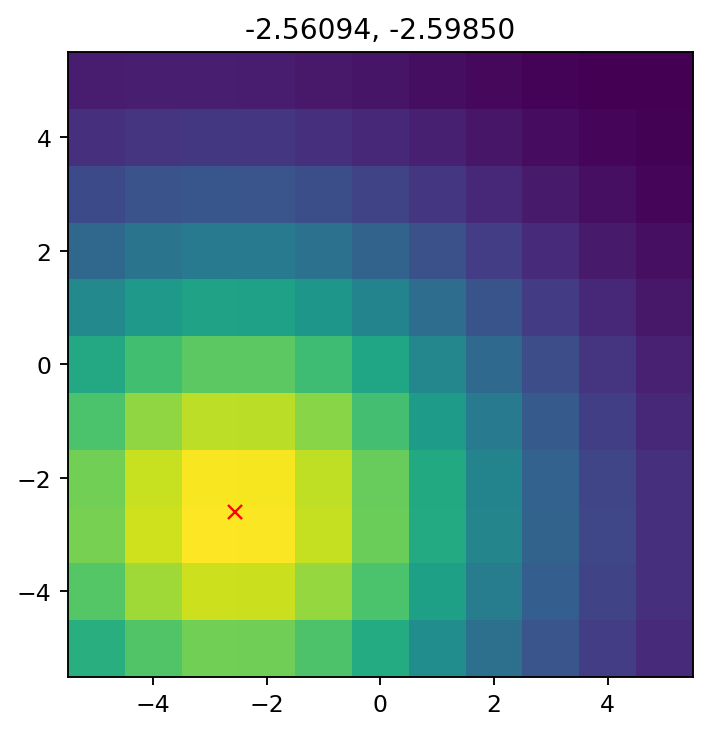

In [33]:
# Now for the subfield tests. The underestimate is much more pronounced.
sfx, sfy = 32, 32
sfwindow = apod_mask(sfx, sfy, fraction=apod_frac)
# sfwindow = np.ones((sfx, sfy))
sfwindow_shifted = np.zeros((sfy, sfx))
sfwsx0, sfwsx1, sfwsy0, sfwsy1 = max(-dx, 0), min(-dx, 0)+sfx, max(-dy, 0), min(-dy, 0)+sfy
sfwindow_shifted[sfwsy0:sfwsy1, sfwsx0:sfwsx1] = sfwindow[sfwsy0+dy:sfwsy1+dy, sfwsx0+dx:sfwsx1+dx]
sflowpass = smouth(sfx, sfy)
# sflowpass = np.ones((sfx, sfy))
nsfx = nx // sfx
nsfy = ny // sfy
subfields = np.zeros((nsfy, nsfx, sfy, sfx))
ccs = np.zeros((nsfy, nsfx, sfy, sfx))
for i in range(nsfy):
    for j in range(nsfx):
        ss0 = im0[sfy*i:sfy*(i+1), sfx*j:sfx*(j+1)].copy()
        ss1 = im1[sfy*i:sfy*(i+1), sfx*j:sfx*(j+1)].copy()
        ss0 -= surface_fit(ss0, 1)
        ss1 -= surface_fit(ss1, 1)
        subfields[i, j] = ss0
        fft_ss0 = np.fft.fft2(ss0*sfwindow)
        fft_ss1 = np.fft.fft2(ss1*sfwindow)
#         fft_ss1 = np.fft.fft2(ss1*sfwindow_shifted)
        ccs[i, j] = np.real(np.fft.fftshift(np.fft.ifft2(fft_ss0 * fft_ss1.conj() * sflowpass)))
ccs_mean = ccs.mean((0, 1))
# ccs_mean_sft = np.roll(ccs_mean, (sfy//2, sfx//2), axis=(0, 1))
mmx, mmy = crosscor_maxpos(ccs_mean, 2)
mmx = (mmx + sfx) % sfx - sfx//2
mmy = (mmy + sfy) % sfy - sfy//2
plt.imshow(ccs_mean[sfy//2-cc_range:sfy//2+cc_range+1, sfx//2-cc_range:sfx//2+cc_range+1],
           extent=[-cc_range-0.5, cc_range+0.5, -cc_range-0.5, cc_range+0.5], origin='lower')
plt.plot(mmx, mmy, 'xr')
plt.title('{:.5f}, {:.5f}'.format(mmx, mmy))

In [34]:
# Once again, calculate the Hessian and gamma^2...
ccs_xx = np.gradient(np.gradient(ccs_mean, axis=1), axis=1)
ccs_xy = np.gradient(np.gradient(ccs_mean, axis=0), axis=1)
ccs_yy = np.gradient(np.gradient(ccs_mean, axis=0), axis=0)
Hn = (ccs_xx*ccs_yy - ccs_xy**2)[round(mmy) + sfy//2, round(mmx) + sfx//2] / np.amax(ccs_mean)**2
gamma2 = Hn**-0.5
print(gamma2)

11.902503458449804


In [35]:
# ...and correct the inferred shifts. Much better, at least for the mean cross-correlation.
delta_x = mmx / (1 - 0.8*gamma2/(0.25*sfx)**2)
delta_y = mmy / (1 - 0.8*gamma2/(0.25*sfy)**2)
print(delta_x, delta_y)

-3.0085564933354183 -3.05268356162278


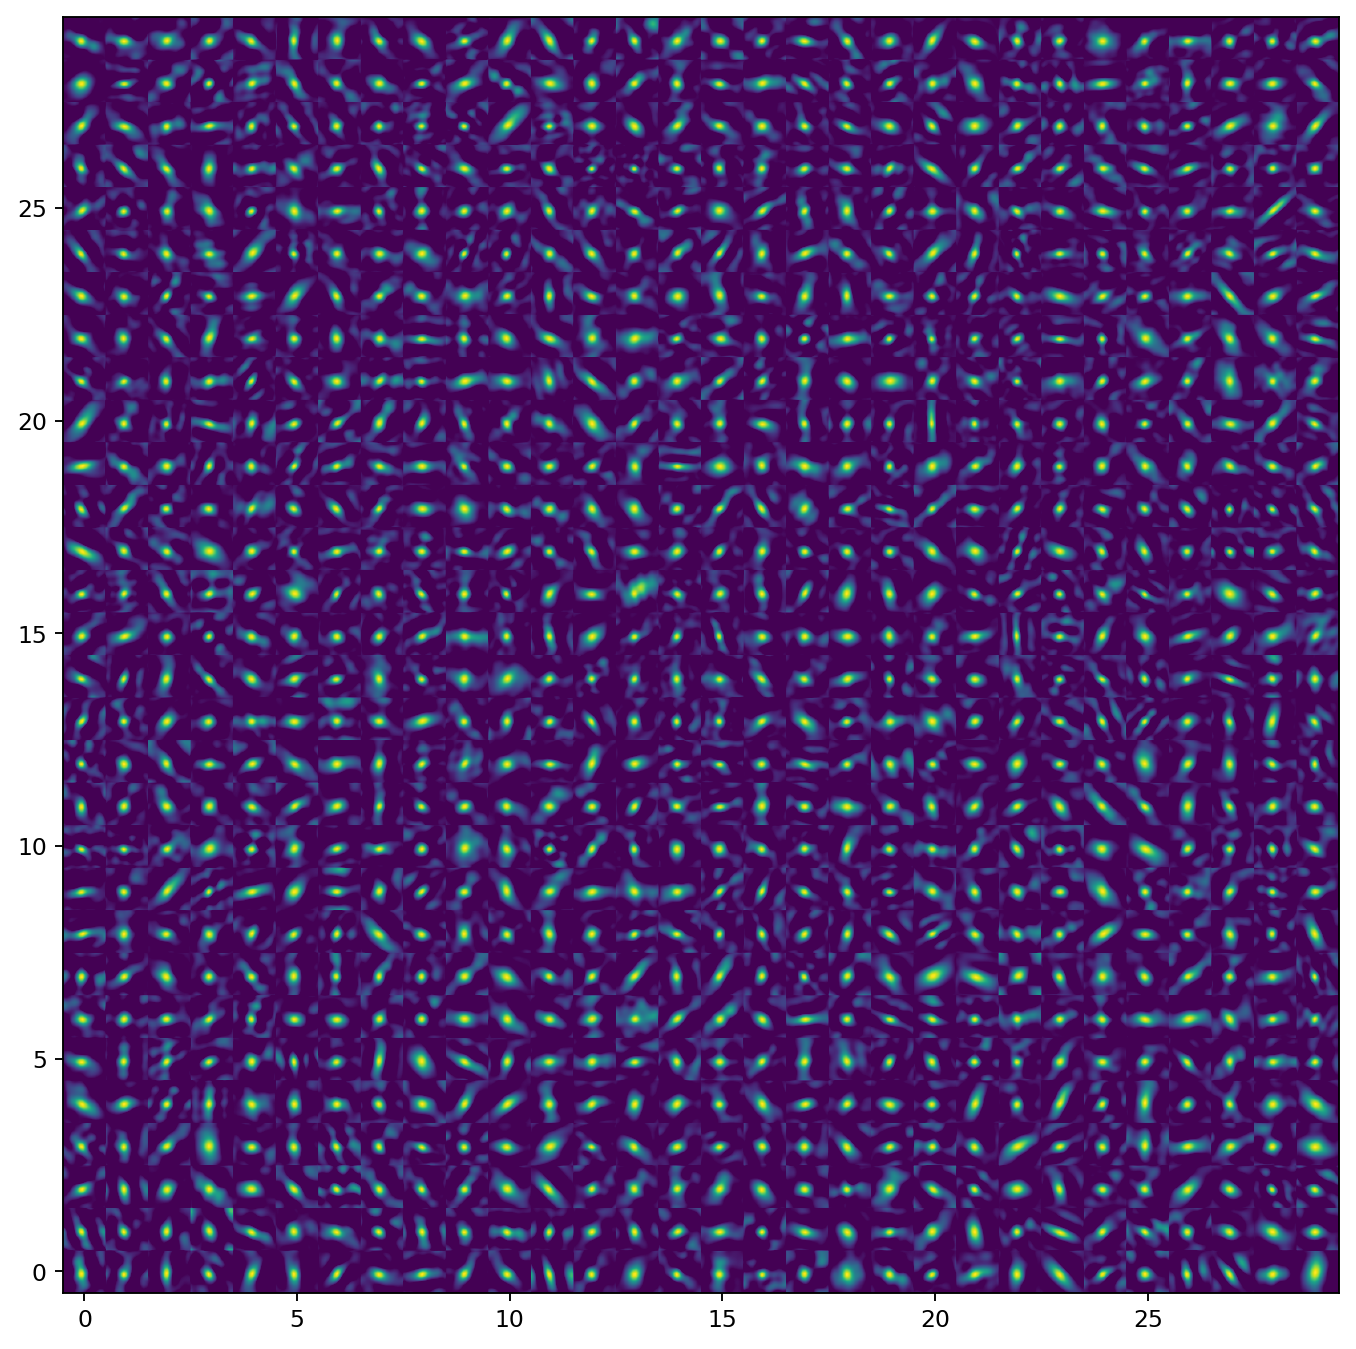

In [1317]:
# Let's take a look at the individual cross-correlations for each subfield. Not so simple, is it?
plt.figure(figsize=(10, 10))
# ccs_2d = np.moveaxis(ccs, 1, 2).reshape((nsfy*sfy, nsfx*sfx))
ccs_2d = np.zeros((nsfy*sfy, nsfx*sfx))
for i in range(nsfy):
    for j in range(nsfx):
        ccs_2d[sfy*i:sfy*(i+1), sfx*j:sfx*(j+1)] = ccs[i, j]/ccs[i, j].max()
plt.imshow(ccs_2d, origin='lower', extent=[-0.5, nsfx-0.5, -0.5, nsfy-0.5], vmin=0)

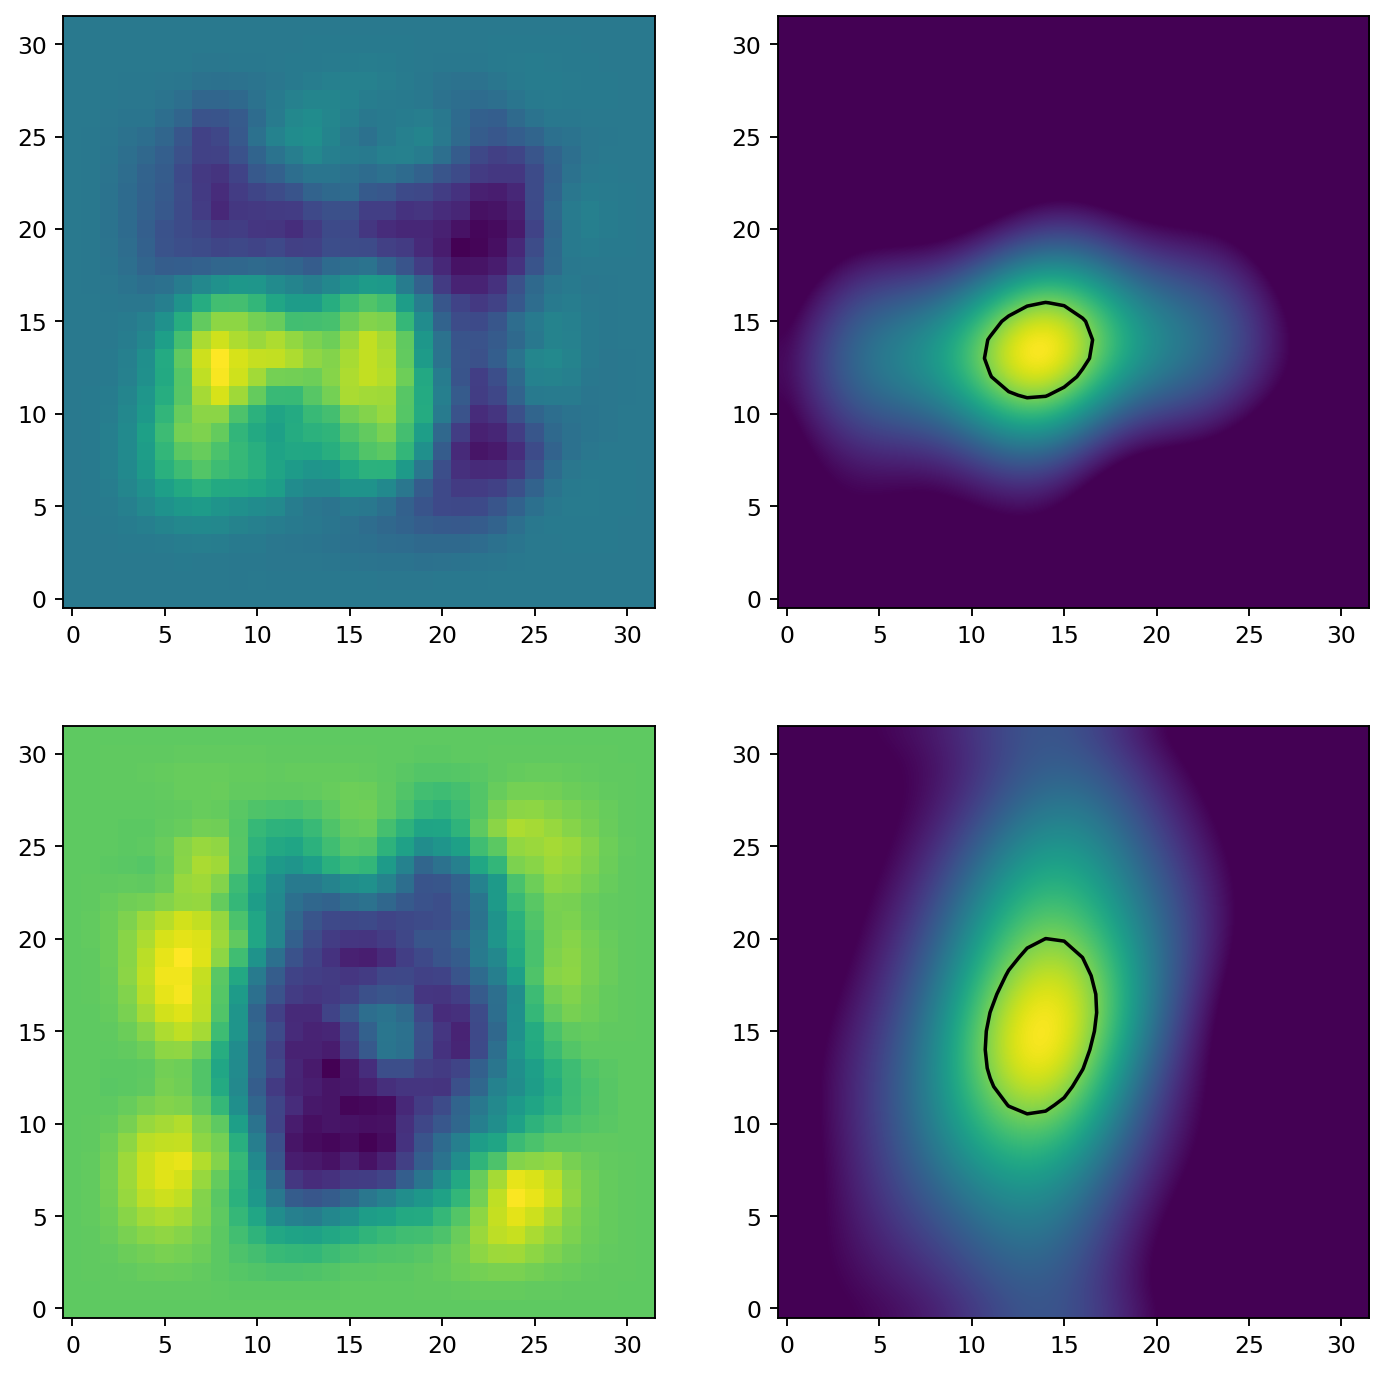

In [36]:
# Look at how the structures in the subfield affect the shape of the cross-correlation function.
plt.figure(figsize=(10, 10))
plt.subplot(221)
i, j = 0, 28
plt.imshow(subfields[i, j]*sfwindow, origin='lower')
plt.subplot(222)
plt.imshow(ccs[i, j], origin='lower', interpolation='bicubic', vmin=0)
C1 = plt.contour(ccs[i, j], levels=[0.8*ccs[i, j].max()], colors='k')
plt.subplot(223)
i, j = 0, 29
plt.imshow(subfields[i, j]*sfwindow, origin='lower')
plt.subplot(224)
plt.imshow(ccs[i, j], origin='lower', interpolation='bicubic', vmin=0)
C2 = plt.contour(ccs[i, j], levels=[0.8*ccs[i, j].max()], colors='k')

(np.float64(10.386024509442407),
 np.float64(17.063484551706576),
 np.float64(10.051625960547103),
 np.float64(20.48375745400292))

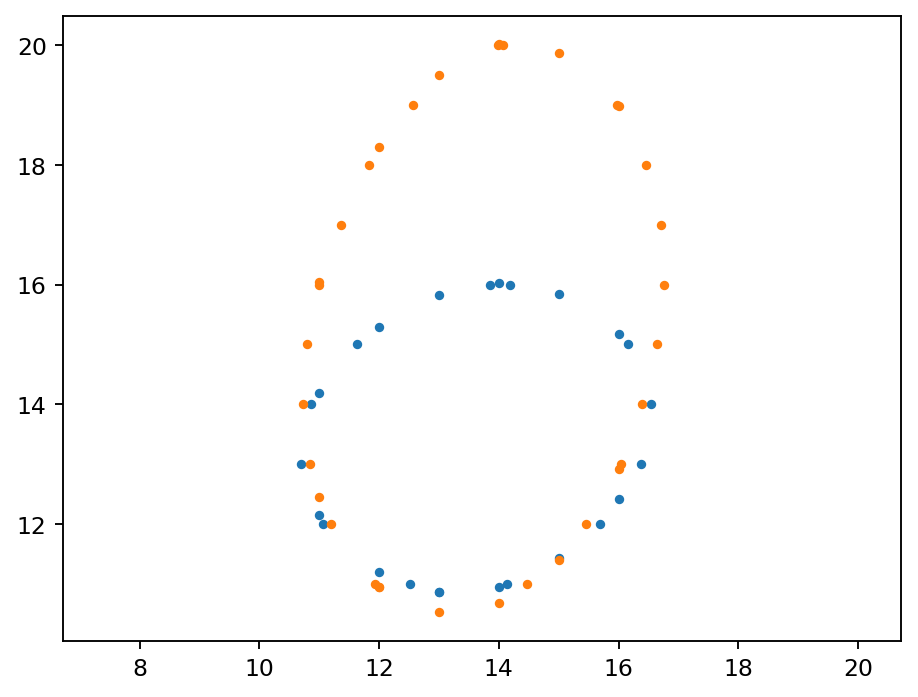

In [38]:
dat1 = C1.allsegs[0][0]
dat2 = C2.allsegs[0][0]
plt.plot(dat1[:, 0], dat1[:, 1], '.')
plt.plot(dat2[:, 0], dat2[:, 1], '.')
plt.axis('equal')

In [39]:
X, Y = dat1[:, 0:1], dat1[:, 1:]
A = np.hstack([X**2, X*Y, Y**2, X, Y])
b = np.ones_like(X)
x = np.linalg.lstsq(A, b)[0].squeeze()
A, B, C, D, E = x
F = -1
print("{:.5f}*X^2 + {:.5f}*X*Y + {:.5f}*Y^2 + {:.5f}*X + {:.5f}*Y = 1".format(A, B, C, D, E))
a = -np.sqrt(2*(A*E**2+C*D**2-B*D*E+(B**2-4*A*C)*F)*
             ((A+C)+np.sqrt((A-C)**2+B**2))) / (B**2-4*A*C)
b = -np.sqrt(2*(A*E**2+C*D**2-B*D*E+(B**2-4*A*C)*F)*
             ((A+C)-np.sqrt((A-C)**2+B**2))) / (B**2-4*A*C)
if b > a: b, a = a, b
x_0 = (2*C*D - B*E)/(B**2 - 4*A*C)
y_0 = (2*A*E - B*D)/(B**2 - 4*A*C)
e = np.sqrt(1 - b**2/a**2)
theta = 0.5*np.arctan2(B, (A-C))
print("a = {:.2f}; b = {:.2f}; x_0 = {:.2f}; y_0 = {:.2f}; r = {:.2f}; e = {:.2f}; theta = {:.2f} deg"\
      .format(a, b, x_0-sfx//2, y_0-sfy//2, np.sqrt(a*b), e, theta*180/np.pi))

-0.00288*X^2 + 0.00095*X*Y + -0.00366*Y^2 + 0.06567*X + 0.08567*Y = 1
a = 2.97; b = 2.46; x_0 = -2.38; y_0 = -2.55; r = 2.70; e = 0.56; theta = 25.14 deg


In [40]:
def fit_ellipse(X, Y):
    A, B, C, D, E = np.linalg.lstsq(np.hstack([X**2, X*Y, Y**2, X, Y]), np.ones_like(X))[0].squeeze()
    a = -np.sqrt(2*(A*E**2+C*D**2-B*D*E-(B**2-4*A*C))*((A+C)+np.sqrt((A-C)**2+B**2))) / (B**2-4*A*C)
    b = -np.sqrt(2*(A*E**2+C*D**2-B*D*E-(B**2-4*A*C))*((A+C)-np.sqrt((A-C)**2+B**2))) / (B**2-4*A*C)
    if b > a: b, a = a, b
    x_0 = (2*C*D - B*E)/(B**2 - 4*A*C)
    y_0 = (2*A*E - B*D)/(B**2 - 4*A*C)
    e = np.sqrt(1 - b**2/a**2)
    theta = 0.5*np.arctan2(B, (A-C))
    
    return a, b, x_0, y_0, e, theta

In [41]:
r_all = np.zeros((nsfy, nsfx))
e_all = np.zeros((nsfy, nsfx))
theta_all = np.zeros((nsfy, nsfx))
for i in range(nsfy):
    for j in range(nsfx):
        C = plt.contour(ccs[i, j], levels=[0.8*ccs[i, j].max()], alpha=0.1).allsegs[0][0]
        X, Y = C[:, 0:1], C[:, 1:]
        a, b, x_0, y_0, e, theta = fit_ellipse(X, Y)
        r_all[i, j] = np.sqrt(a*b)
        e_all[i, j] = e
        theta_all[i, j] = theta
plt.close()

In [46]:
# Let's see how each subfield fares with the usual analysis. Find the subpixel maximum for each subfield...
mmx_all = np.zeros((nsfy, nsfx))
mmy_all = np.zeros((nsfy, nsfx))
for i in range(nsfy):
    for j in range(nsfx):
        mmx_all[i, j], mmy_all[i, j] = crosscor_maxpos(ccs[i, j], 2)
mmx_all = (mmx_all + sfx) % sfx - sfx//2
mmy_all = (mmy_all + sfy) % sfy - sfy//2

In [43]:
# ...compute the gradients, Hessian, gamma^2...
ccs_all_xx = np.gradient(np.gradient(ccs, axis=3), axis=3)
ccs_all_xy = np.gradient(np.gradient(ccs, axis=2), axis=3)
ccs_all_yy = np.gradient(np.gradient(ccs, axis=2), axis=2)
H_all_full = (ccs_all_xx * ccs_all_yy - ccs_all_xy**2)
H_all = H_all_full.max((2, 3))
ccs_all_max = ccs.max((2, 3))
Hn_all = H_all / ccs_all_max**2
gamma_all = Hn_all**-0.5

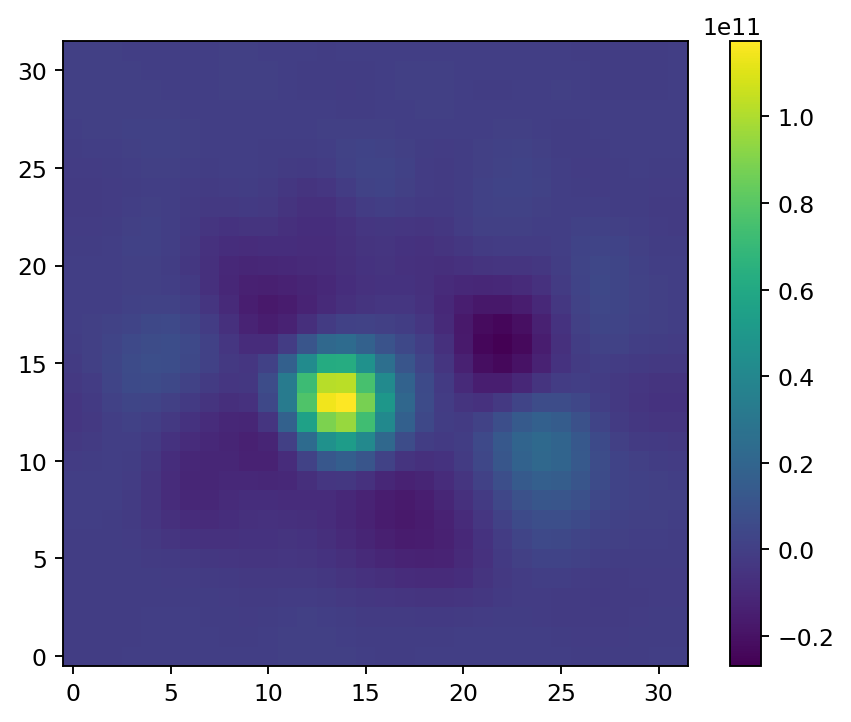

In [44]:
plt.imshow(H_all_full[2, 2], origin='lower')
plt.colorbar()

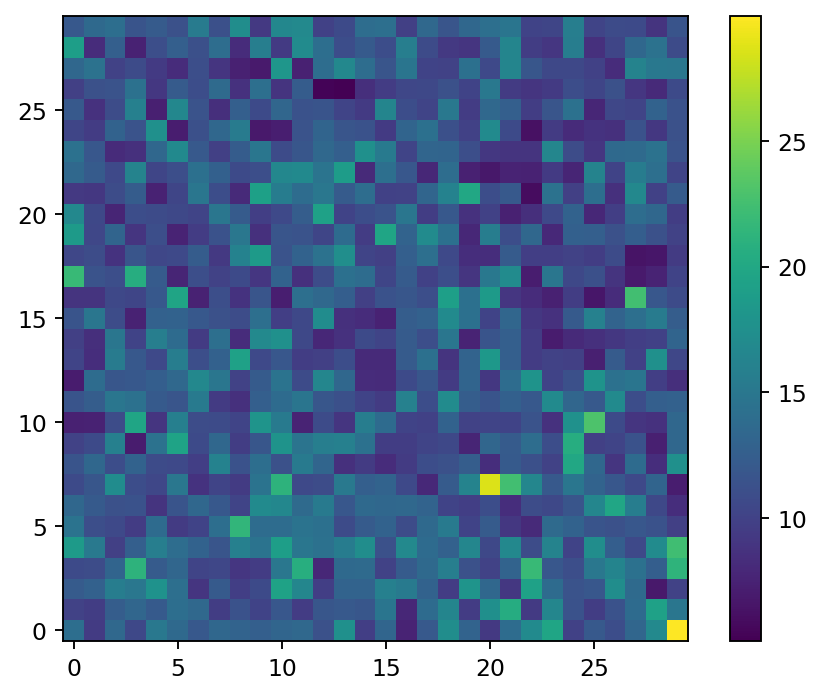

In [45]:
# (gamma^2 looks like this, by the way)
plt.imshow(gamma_all, origin='lower')
plt.colorbar()

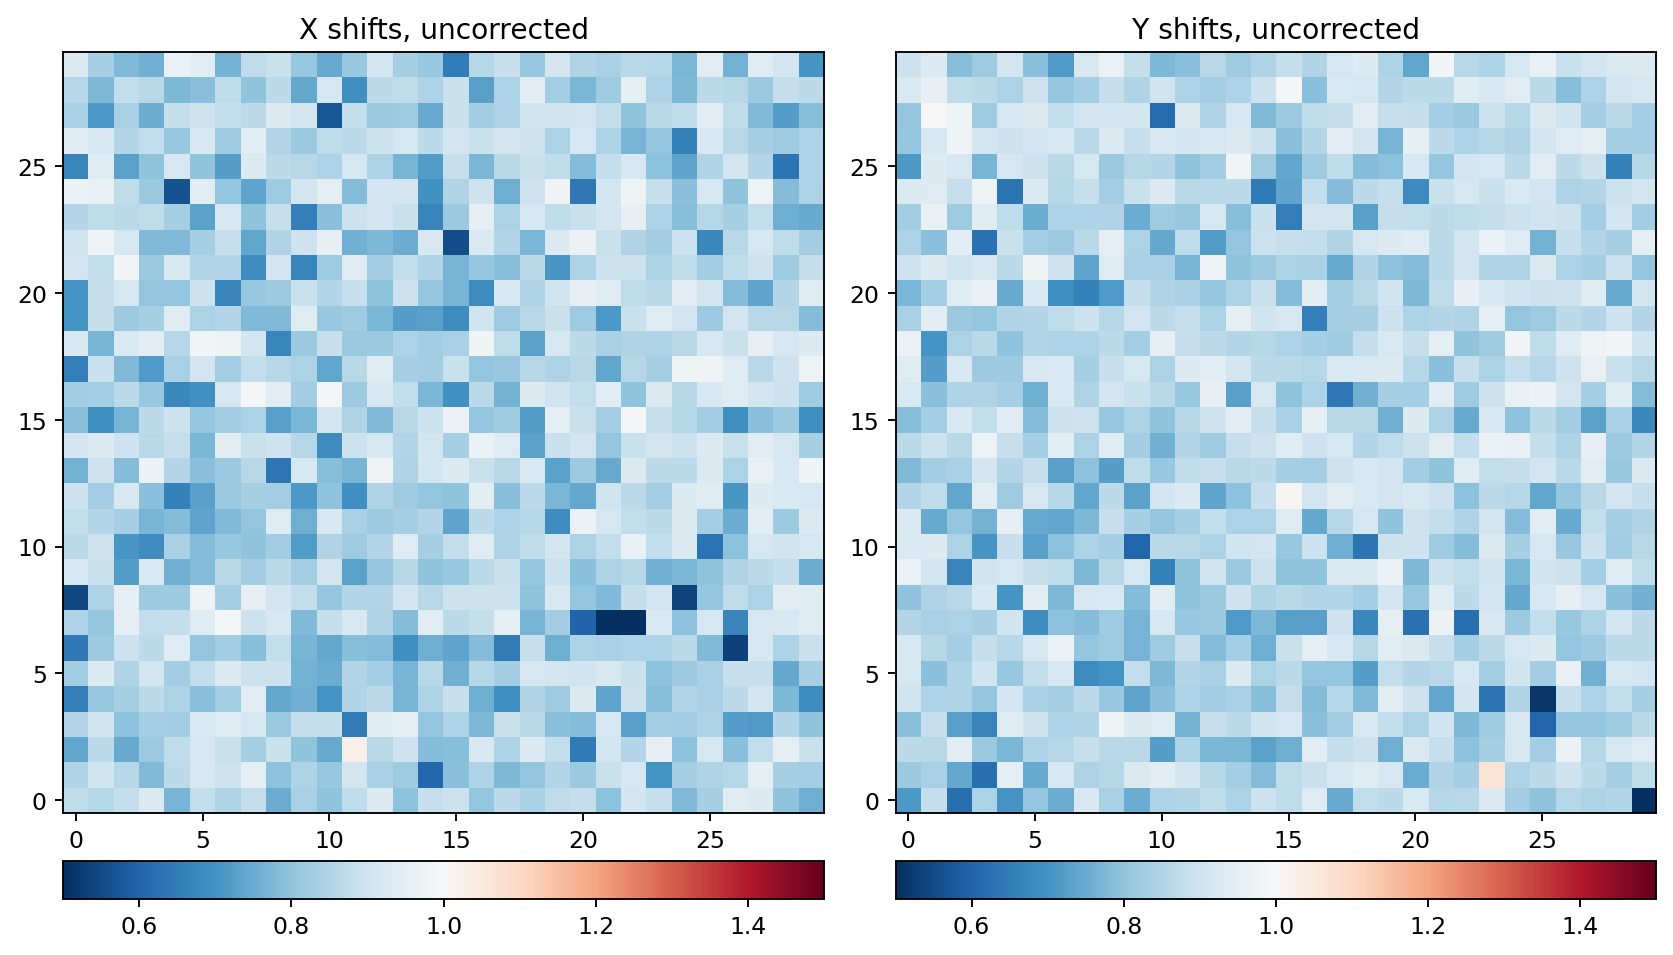

In [48]:
# ...and the uncorrected shifts look like this! Consistently underestimated.
plt.figure(figsize=(10, 6))
vmin, vmax = 0.5, 1.5
plt.subplot(121)
plt.imshow(mmx_all/dx, origin='lower', cmap='RdBu_r', vmin=vmin, vmax=vmax)
plt.colorbar(orientation='horizontal', pad=0.05)
plt.title('X shifts, uncorrected')
plt.subplot(122)
plt.imshow(mmy_all/dy, origin='lower', cmap='RdBu_r', vmin=vmin, vmax=vmax)
plt.colorbar(orientation='horizontal', pad=0.05)
plt.title('Y shifts, uncorrected')
plt.tight_layout()

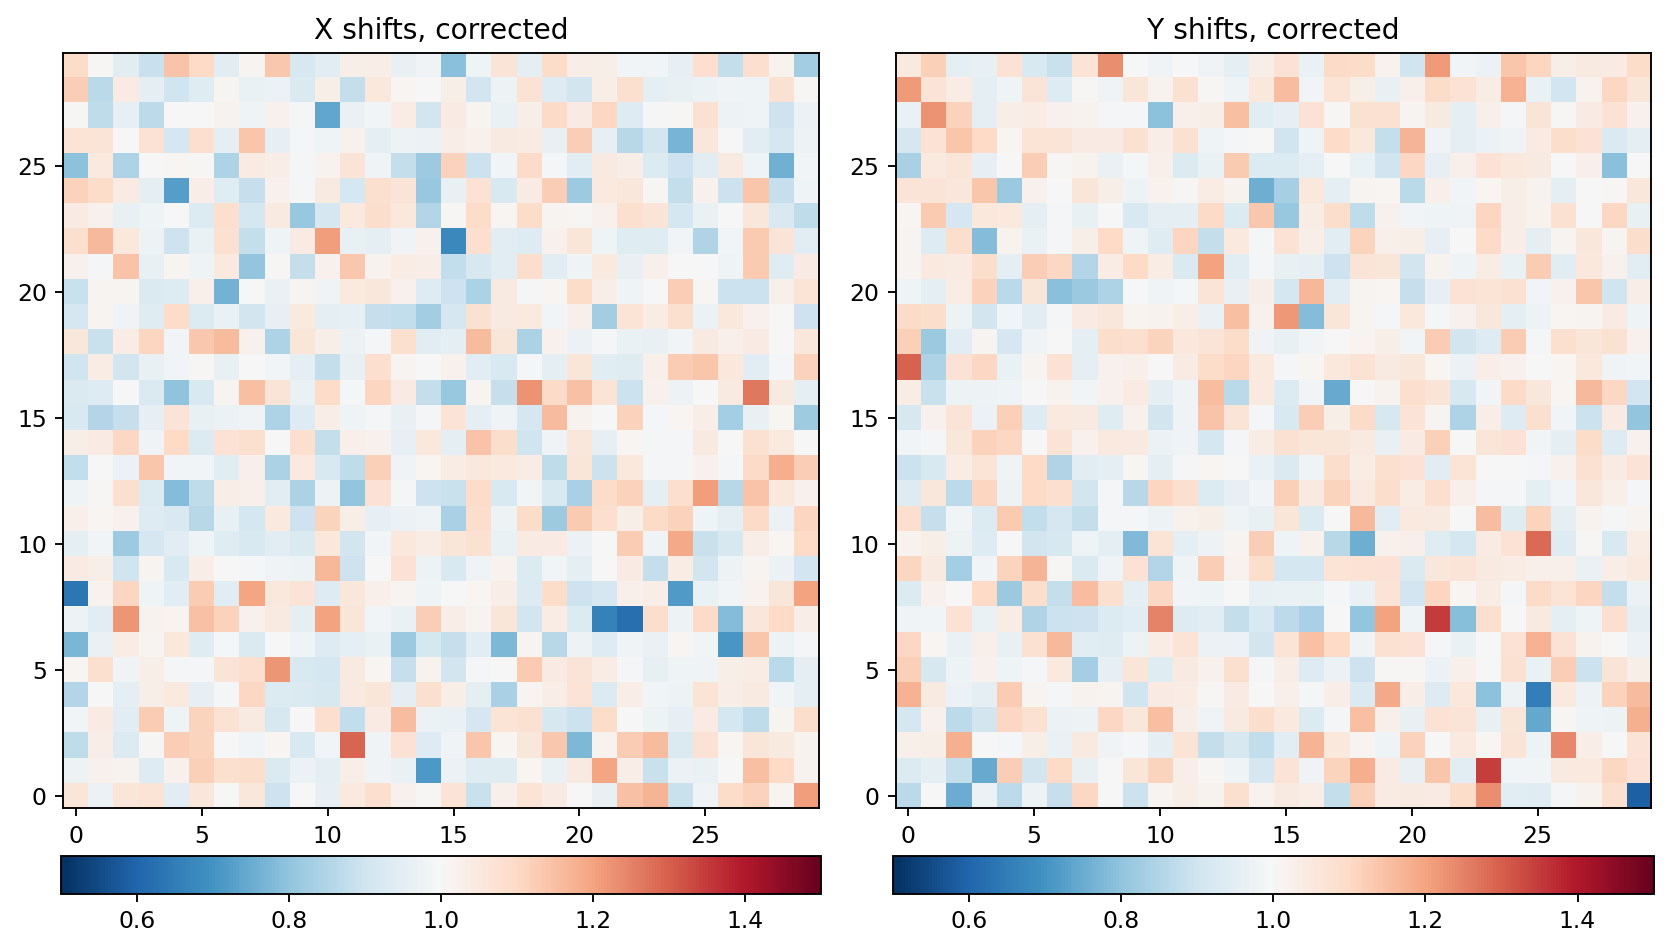

In [1328]:
# Apply the corrections with gamma^2, and this is what we get.
delta_x_all = mmx_all / (1 - 0.8*gamma_all/(0.25*sfx)**2)
delta_y_all = mmy_all / (1 - 0.8*gamma_all/(0.25*sfy)**2)
plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.imshow(delta_x_all/dx, origin='lower', cmap='RdBu_r', vmin=vmin, vmax=vmax)
plt.colorbar(orientation='horizontal', pad=0.05)
plt.title('X shifts, corrected')
plt.subplot(122)
plt.imshow(delta_y_all/dy, origin='lower', cmap='RdBu_r', vmin=vmin, vmax=vmax)
plt.colorbar(orientation='horizontal', pad=0.05)
plt.title('Y shifts, corrected')
plt.tight_layout()

Text(0.5, 1.0, 'Total shift magnitude, corrected')

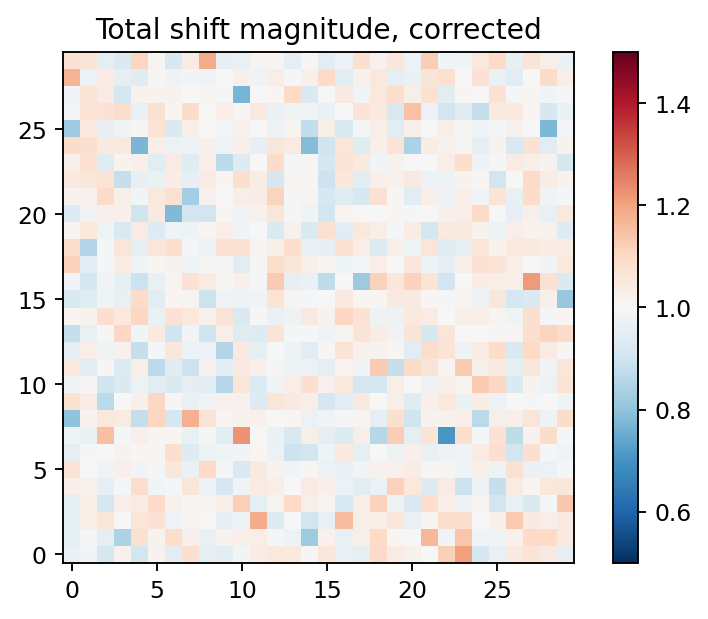

In [1329]:
# If we look just at the shift magnitude, there's less variance.
shift_mag_all = (delta_x_all**2 + delta_y_all**2)**0.5 / (dx**2 + dy**2)**0.5
plt.imshow(shift_mag_all, origin='lower', cmap='RdBu_r', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title('Total shift magnitude, corrected')

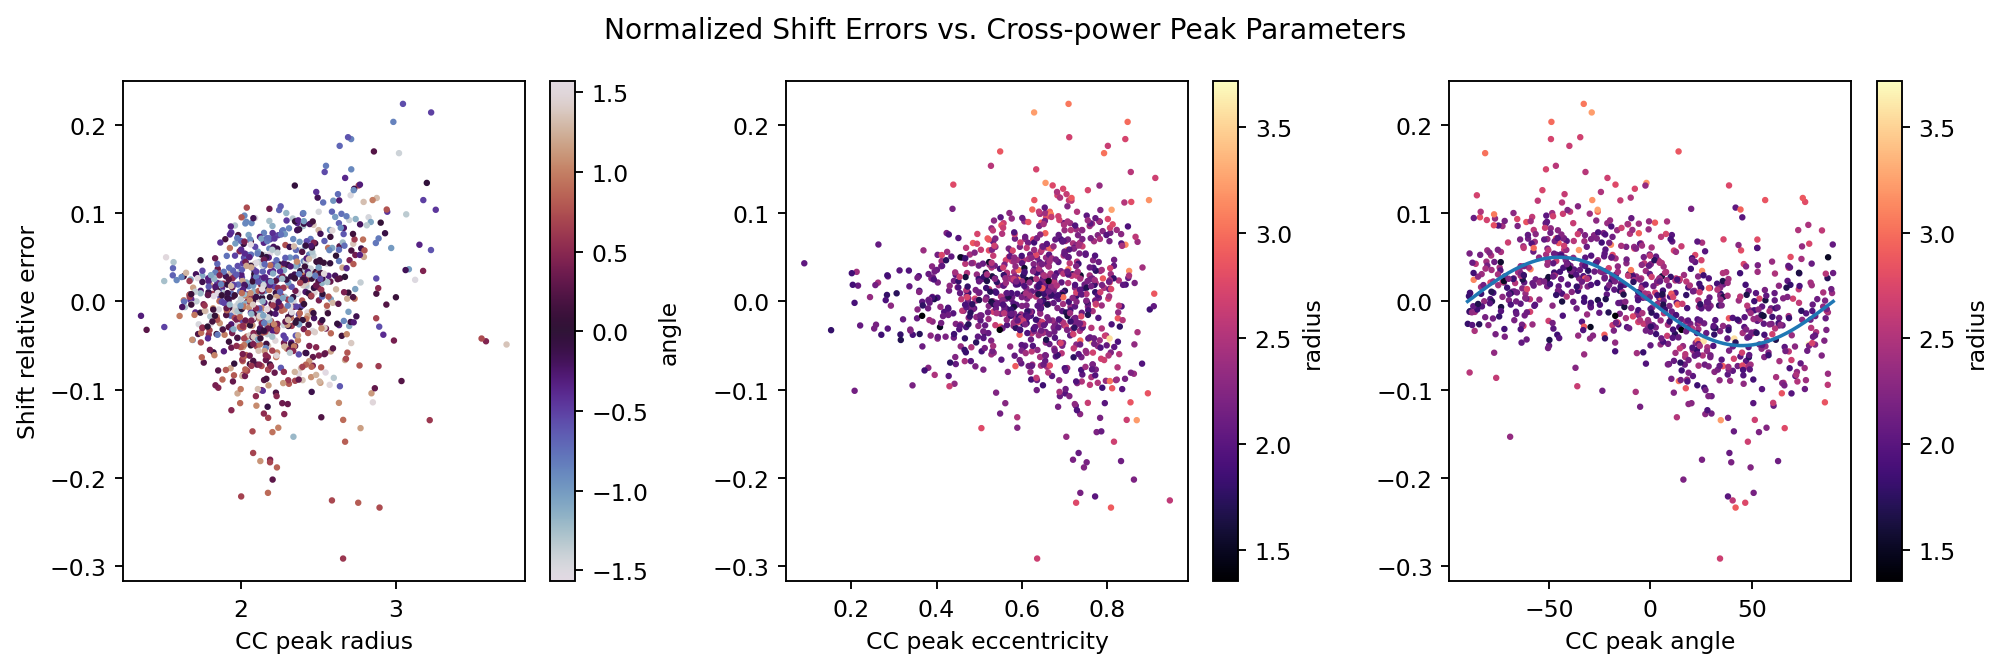

In [1337]:
plt.figure(figsize=(12, 4), facecolor='w')
plt.subplot(131)
plt.scatter(r_all.ravel(), shift_mag_all.ravel() - 1, s=3, c=theta_all.ravel(), cmap='twilight')
plt.colorbar(label='angle')
plt.xlabel('CC peak radius')
plt.ylabel('Shift relative error')
plt.subplot(132)
plt.scatter(e_all.ravel(), shift_mag_all.ravel() - 1, s=3, c=r_all.ravel(), cmap='magma')
plt.colorbar(label='radius')
plt.xlabel('CC peak eccentricity')
plt.subplot(133)
plt.scatter(theta_all.ravel()*180/np.pi, shift_mag_all.ravel() - 1, s=3, c=r_all.ravel(), cmap='magma')
plt.colorbar(label='radius')
plt.xlabel('CC peak angle')
x = np.linspace(-90, 90, 181)
y = -0.05*np.cos(2*x*np.pi/180 - 2*np.arctan2(dy, dx))
plt.plot(x, y)
plt.suptitle('Normalized Shift Errors vs. Cross-power Peak Parameters')
plt.tight_layout()

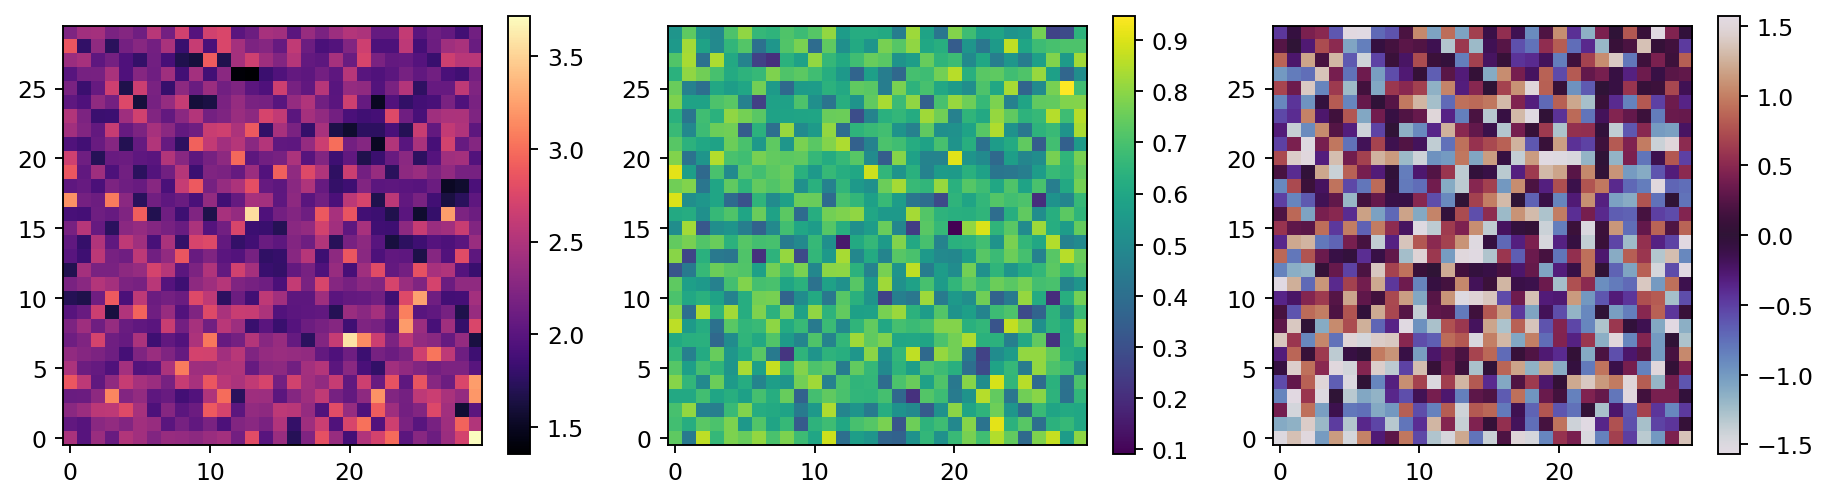

In [1336]:
plt.figure(figsize=(11, 3))
plt.subplot(131)
plt.imshow(r_all, origin='lower', cmap='magma')
plt.colorbar()
plt.subplot(132)
plt.imshow(e_all, origin='lower')
plt.colorbar()
plt.subplot(133)
plt.imshow(theta_all, origin='lower', cmap='twilight', vmin=-np.pi/2, vmax=np.pi/2)
plt.colorbar()
plt.tight_layout()